# Neighbour-based Collaborative Filtering

## User-based filtering

User-based collaborative filtering is also called user-user collaborative filtering. It is a type of recommendation system algorithm that uses user similarity to make product recommendations.

In this tutorial, we will talk about
* What is user-based (user-user) collaborative filtering?
* How to create a user-product matrix?
* How to process data for user-based collaborative filtering?
* How to identify similar users?
* How to narrow down the items pool?
* How to rank items for the recommendation?
* How to predict the rating score?


# Step 0: User-Based Collaborative Filtering Recommendation Algorithm

The process for creating a User Based recommendation system is as follows:

    Select a user with the movies the user has watched

    Add movieIds to the movies watched by the user for easy recommendation

    Based on his rating to movies, find the top X neighbours

    Get the watched movie record of the user for each neighbour.

    Calculate a similarity score using some formula
    
    Recommend the items with the highest score

Firstly, let's understand how User-based collaborative filtering works.

User-based collaborative filtering makes recommendations based on user-product interactions in the past. The assumption behind the algorithm is that similar users like similar products.

User-based collaborative filtering algorithm usually has the following steps:

1. Find similar users based on interactions with common items.
2. Identify the items rated high by similar users but have not been exposed to the active user of interest.
3. Calculate the weighted average score for each item.
4. Rank items based on the score and pick top n items to recommend.

# Step 1: Import Python Libraries

In the first step, we will import Python libraries `pandas`, `numpy`, and `scipy.stats`. These three libraries are for data processing and calculations.

We also imported `seaborn` for visualization and `cosine_similarity` for calculating similarity score.

In [1]:
# Data processing
import pandas as pd
import numpy as np
import scipy.stats

# Visualization
import seaborn as sns

# Similarity
from sklearn.metrics.pairwise import cosine_similarity

/tmp/ipykernel_112778/2913905833.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Step 2: Download And Read In Data

This tutorial uses the movielens dataset. This dataset contains actual user ratings of movies.

In step 2, we will follow the steps below to get the datasets:
1. Go to https://grouplens.org/datasets/movielens/
2. Download the 100k dataset with the file name "ml-latest-small.zip"
3. Unzip "ml-latest-small.zip"
4. Copy the "ml-latest-small" folder to your project folder

Those who are using Google Colab for this analysis need to mount Google Drive to read the dataset. You can ignore the code below if you are not using Google Colab.

Please check out [Google Colab Tutorial for Beginners](https://medium.com/towards-artificial-intelligence/google-colab-tutorial-for-beginners-834595494d44) for details about using Google Colab for data science projects.

There are multiple datasets in the 100k movielens folder. For this tutorial, we will use two ratings and movies.

Now let's read in the rating data.

In [2]:
# Read in data
ratings=pd.read_csv('ml-1m/ratings.csv')

# Take a look at the data
ratings.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


There are four columns in the ratings dataset, userID, movieID, rating, and timestamp.

The dataset has over 100k records, and there is no missing data.

In [3]:
# Get the dataset information
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype
---  ------     --------------    -----
 0   UserID     1000209 non-null  int64
 1   MovieID    1000209 non-null  int64
 2   Rating     1000209 non-null  int64
 3   Timestamp  1000209 non-null  int64
dtypes: int64(4)
memory usage: 30.5 MB


The 100k ratings are from 610 users on 9724 movies. The rating has ten unique values from 0.5 to 5.

In [4]:
# Number of users
print('The ratings dataset has', ratings['userId'].nunique(), 'unique users')

# Number of movies
print('The ratings dataset has', ratings['movieId'].nunique(), 'unique movies')

# Number of ratings
print('The ratings dataset has', ratings['rating'].nunique(), 'unique ratings')

# List of unique ratings
print('The unique ratings are', sorted(ratings['rating'].unique()))

KeyError: 'userId'

Next, let's read in the movies data to get the movie names.

The movies dataset has movieID, title, and genres.

In [ ]:
# Read in data
movies = pd.read_csv('ml-1m/movies.csv')

# Take a look at the data
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


Using 'movieID' as the matching key, we appended movie information to the rating dataset and named it 'df'. So now we have the movie tile and movie rating in the same dataset!


In [ ]:
# Merge ratings and movies datasets
df = pd.merge(ratings, movies, on='movieId', how='inner')

# Take a look at the data
df.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


In [ ]:
no_user_voted = ratings.groupby('movieId')['rating'].agg('count')
no_movies_voted = ratings.groupby('userId')['rating'].agg('count')

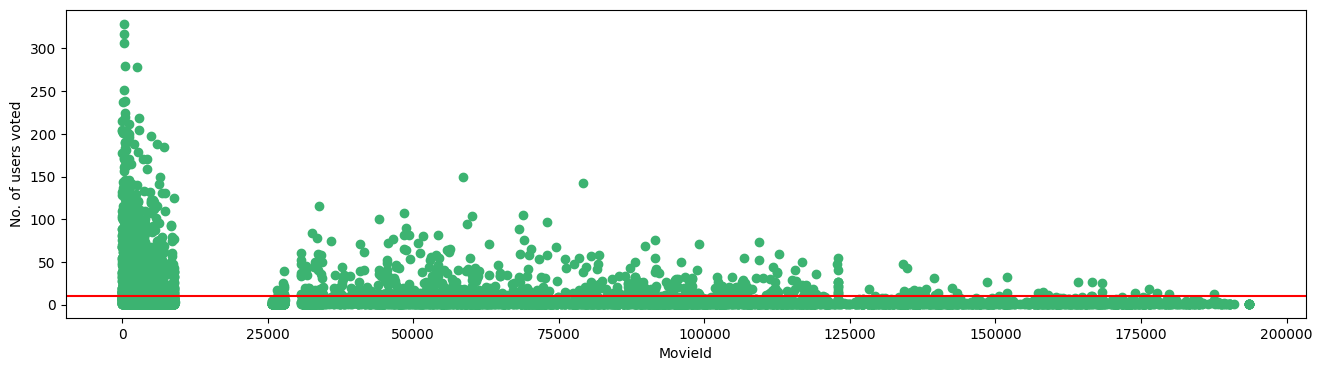

In [ ]:
import matplotlib.pyplot as plt
f,ax = plt.subplots(1,1,figsize=(16,4))
# ratings['rating'].plot(kind='hist')
plt.scatter(no_user_voted.index,no_user_voted,color='mediumseagreen')
plt.axhline(y=10,color='r')
plt.xlabel('MovieId')
plt.ylabel('No. of users voted')
plt.show()

# Step 3: Exploratory Data Analysis (EDA)

In step 3, we need to filter the movies and keep only those with over 100 ratings for the analysis. This is to make the calculation manageable by the Google Colab memory.

To do that, we first group the movies by title, count the number of ratings, and keep only the movies with greater than 100 ratings.

The average ratings for the movies are calculated as well.

From the `.info()` output, we can see that there are 134 movies left.

In [ ]:
# Aggregate by movie
agg_ratings = df.groupby('title').agg(mean_rating = ('rating', 'mean'),
                                                number_of_ratings = ('rating', 'count')).reset_index()

# Keep the movies with over 100 ratings
agg_ratings_GT100 = agg_ratings[agg_ratings['number_of_ratings']>70]
agg_ratings_GT100.info()

<class 'pandas.core.frame.DataFrame'>
Index: 252 entries, 74 to 9621
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              252 non-null    object 
 1   mean_rating        252 non-null    float64
 2   number_of_ratings  252 non-null    int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 7.9+ KB


Let's check what the most popular movies and their ratings are.

In [ ]:
# Check popular movies
agg_ratings_GT100.sort_values(by='number_of_ratings', ascending=False).head()

,title,mean_rating,number_of_ratings
3158,Forrest Gump (1994),4.164134,329
7593,"Shawshank Redemption, The (1994)",4.429022,317
6865,Pulp Fiction (1994),4.197068,307
7680,"Silence of the Lambs, The (1991)",4.161290,279
5512,"Matrix, The (1999)",4.192446,278


Next, let's use a `jointplot` to check the correlation between the average rating and the number of ratings.

We can see an upward trend from the scatter plot, showing that popular movies get higher ratings.

The average rating distribution shows that most movies in the dataset have an average rating of around 4.

The number of rating distribution shows that most movies have less than 150 ratings.

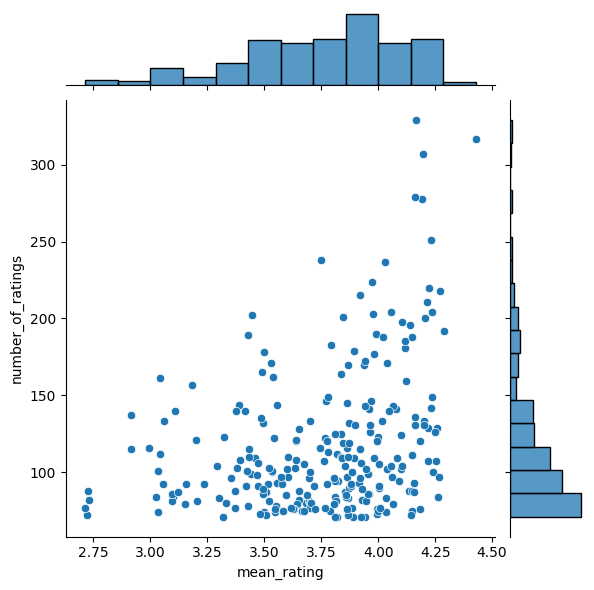

In [ ]:
# Visulization
sns.jointplot(x='mean_rating', y='number_of_ratings', data=agg_ratings_GT100)

To keep only the 134 movies with more than 100 ratings, we need to join the movie with the user-rating level dataframe.

`how='inner'` and `on='title'` ensure that only the movies with more than 100 ratings are included.

In [ ]:
# Merge data
df_GT100 = pd.merge(df, agg_ratings_GT100[['title']], on='title', how='inner')
df_GT100.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29719 entries, 0 to 29718
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   userId     29719 non-null  int64  
 1   movieId    29719 non-null  int64  
 2   rating     29719 non-null  float64
 3   timestamp  29719 non-null  int64  
 4   title      29719 non-null  object 
 5   genres     29719 non-null  object 
dtypes: float64(1), int64(3), object(2)
memory usage: 1.4+ MB


In [ ]:
# Number of users
print('The ratings dataset has', df_GT100['userId'].nunique(), 'unique users')

# Number of movies
print('The ratings dataset has', df_GT100['movieId'].nunique(), 'unique movies')

# Number of ratings
print('The ratings dataset has', df_GT100['rating'].nunique(), 'unique ratings')

# List of unique ratings
print('The unique ratings are', sorted(df_GT100['rating'].unique()))

The ratings dataset has 602 unique users
The ratings dataset has 252 unique movies
The ratings dataset has 10 unique ratings
The unique ratings are [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]


# Step 4: Create User-Movie Matrix

In step 4, we will transform the dataset into a matrix format. The rows of the matrix are users, and the columns of the matrix are movies. The value of the matrix is the user rating of the movie if there is a rating. Otherwise, it shows 'NaN'.

In [ ]:
# Create user-item matrix
matrix = df_GT100.pivot_table(index='userId', columns='title', values='rating')
matrix.head(10)

title,2001: A Space Odyssey (1968),300 (2007),"40-Year-Old Virgin, The (2005)",Ace Ventura: Pet Detective (1994),Ace Ventura: When Nature Calls (1995),Addams Family Values (1993),Airplane! (1980),Aladdin (1992),Alien (1979),Aliens (1986),...,WALL·E (2008),Waterworld (1995),What's Eating Gilbert Grape (1993),When Harry Met Sally... (1989),While You Were Sleeping (1995),Who Framed Roger Rabbit? (1988),Willy Wonka & the Chocolate Factory (1971),"Wizard of Oz, The (1939)",X-Men (2000),X2: X-Men United (2003)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,5.0,5.0,5.0,5.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,5.0,4.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,4.0,5.0,NaN,NaN
5,NaN,NaN,NaN,3.0,NaN,3.0,NaN,4.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,3.0,2.0,3.0,NaN,5.0,NaN,NaN,...,NaN,3.0,5.0,NaN,4.0,NaN,3.0,NaN,NaN,NaN
7,4.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.5,4.0
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,3.0,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Step 5: Data Normalization

Since some people tend to give a higher rating than others, we normalize the rating by extracting the average rating of each user.

After normalization, the movies with a rating less than the user's average rating get a negative value, and the movies with a rating more than the user's average rating get a positive value.

In [ ]:
# Normalize user-item matrix
matrix_norm = matrix.subtract(matrix.mean(axis=1), axis = 'rows')
matrix_norm.head()

title,2001: A Space Odyssey (1968),300 (2007),"40-Year-Old Virgin, The (2005)",Ace Ventura: Pet Detective (1994),Ace Ventura: When Nature Calls (1995),Addams Family Values (1993),Airplane! (1980),Aladdin (1992),Alien (1979),Aliens (1986),...,WALL·E (2008),Waterworld (1995),What's Eating Gilbert Grape (1993),When Harry Met Sally... (1989),While You Were Sleeping (1995),Who Framed Roger Rabbit? (1988),Willy Wonka & the Chocolate Factory (1971),"Wizard of Oz, The (1939)",X-Men (2000),X2: X-Men United (2003)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.384615,NaN,...,NaN,NaN,NaN,NaN,NaN,0.615385,0.615385,0.615385,0.615385,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,1.571429,0.571429,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.571429,1.571429,NaN,NaN
5,NaN,NaN,NaN,-0.5,NaN,-0.5,NaN,0.500000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Step 6: Identify Similar Users

There are different ways to measure similarities. Pearson correlation and cosine similarity are two widely used methods.

In this tutorial, we will calculate the user similarity matrix using Pearson correlation.

In [ ]:
# User similarity matrix using Pearson correlation
user_similarity = matrix_norm.T.corr()
user_similarity.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
userId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,NaN,NaN,0.254334,0.180151,-0.439941,-0.180724,0.464277,0.904534,-0.037987,...,0.091574,0.254514,-0.051934,-0.500000,0.050292,0.221932,0.153668,0.165927,-0.175412,-0.056849
2,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.695701,...,-0.412837,NaN,-1.000000,NaN,NaN,0.583333,NaN,-0.229416,NaN,0.757350
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.254334,NaN,NaN,1.000000,-0.398485,0.418161,0.706784,0.063888,NaN,0.541119,...,-0.348903,0.314286,0.161270,-0.158114,0.518328,0.018159,0.217604,-0.367802,NaN,-0.184811
5,0.180151,NaN,NaN,-0.398485,1.000000,-0.013482,0.328889,0.028347,NaN,-0.777714,...,0.000000,0.209004,0.190885,0.063383,-0.290482,0.305477,0.228218,0.211898,0.384111,0.040582


Those who are interested in using cosine similarity can refer to this code. Since `cosine_similarity` does not take missing values, we need to impute the missing values with 0s before the calculation.

In [ ]:
# User similarity matrix using cosine similarity
user_similarity_cosine = cosine_similarity(matrix_norm.fillna(0))
user_similarity_cosine = pd.DataFrame(user_similarity_cosine)
user_similarity_cosine

,0,1,2,3,4,5,6,7,8,9,...,592,593,594,595,596,597,598,599,600,601
0,1.000000,0.006769,0.0,0.131394,0.013403,-0.166077,-0.048751,0.089841,0.079622,-0.020496,...,0.025703,0.006374,-0.027393,-0.085503,0.020971,0.109545,0.079542,0.094401,-0.050352,-0.005395
1,0.006769,1.000000,0.0,-0.086958,0.051044,-0.075821,-0.034456,-0.111195,0.000000,0.181332,...,-0.131977,-0.079277,-0.015514,0.000000,0.000000,0.043772,-0.071227,-0.004425,-0.156010,0.166673
2,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.131394,-0.086958,0.0,1.000000,-0.072342,0.104638,0.157205,0.001546,-0.014227,0.148487,...,-0.091104,0.052912,0.073612,-0.036856,0.123653,-0.002009,0.077012,-0.152042,-0.026533,-0.039945
4,0.013403,0.051044,0.0,-0.072342,1.000000,-0.010877,0.034756,0.023175,0.000000,-0.073555,...,0.028909,0.092604,0.058568,0.031269,-0.117399,0.057873,0.071899,0.060848,0.176800,0.003771
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
597,0.109545,0.043772,0.0,-0.002009,0.057873,-0.075583,0.069325,0.065716,0.058478,-0.111192,...,0.133542,0.071267,0.197471,0.175295,0.038263,1.000000,-0.013340,0.189795,0.122851,0.255067
598,0.079542,-0.071227,0.0,0.077012,0.071899,0.162584,0.044747,0.082821,-0.034587,-0.039492,...,0.084484,0.082363,-0.009621,-0.001521,-0.072560,-0.013340,1.000000,-0.006448,0.032662,-0.005445
599,0.094401,-0.004425,0.0,-0.152042,0.060848,-0.089039,-0.044502,0.154745,0.018147,-0.132252,...,0.179128,0.183436,0.070139,0.077881,-0.007374,0.189795,-0.006448,1.000000,0.119549,0.052330
600,-0.050352,-0.156010,0.0,-0.026533,0.176800,0.110317,0.020411,0.085700,0.000000,-0.065622,...,0.060314,0.100816,0.016091,0.171229,-0.143066,0.122851,0.032662,0.119549,1.000000,-0.102124


Now let's use user ID 1 as an example to illustrate how to find similar users.

We first need to exclude user ID 1 from the similar user list and decide the number of similar users.



In [ ]:
# Pick a user ID
picked_userid = 1

# Remove picked user ID from the candidate list
user_similarity.drop(index=picked_userid, inplace=True)

# Take a look at the data
user_similarity.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
userId,,,,,,,,,,,,,,,,,,,,,
2,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.695701,...,-0.412837,NaN,-1.000000,NaN,NaN,0.583333,NaN,-0.229416,NaN,0.757350
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.254334,NaN,NaN,1.000000,-0.398485,0.418161,0.706784,0.063888,NaN,0.541119,...,-0.348903,0.314286,0.161270,-0.158114,0.518328,0.018159,0.217604,-0.367802,NaN,-0.184811
5,0.180151,NaN,NaN,-0.398485,1.000000,-0.013482,0.328889,0.028347,NaN,-0.777714,...,0.000000,0.209004,0.190885,0.063383,-0.290482,0.305477,0.228218,0.211898,0.384111,0.040582
6,-0.439941,NaN,NaN,0.418161,-0.013482,1.000000,0.000000,-0.144641,NaN,0.957427,...,-0.292770,0.019859,-0.251331,-0.034298,0.066229,-0.247519,0.486395,-0.218778,0.193649,-0.035858


In the user similarity matrix, the values range from -1 to 1, where -1 means opposite movie preference and 1 means same movie preference.

`n = 10` means we would like to pick the top 10 most similar users for user ID 1.

The user-based collaborative filtering makes recommendations based on users with similar tastes, so we need to set a positive threshold. Here we set the `user_similarity_threshold` to be 0.3, meaning that a user must have a Pearson correlation coefficient of at least 0.3 to be considered as a similar user.

After setting the number of similar users and similarity threshold, we sort the user similarity value from the highest and lowest, then printed out the most similar users' ID and the Pearson correlation value.



In [ ]:
# Number of similar users
n = 10

# User similarity threashold
user_similarity_threshold = 0.3

# Get top n similar users
similar_users = user_similarity[user_similarity[picked_userid]>user_similarity_threshold][picked_userid].sort_values(ascending=False)[:n]

# Print out top n similar users
print(f'The similar users for user {picked_userid} are', similar_users)

The similar users for user 1 are userId
598    1.000000
108    1.000000
106    1.000000
508    1.000000
481    1.000000
550    1.000000
535    0.968246
511    0.925820
9      0.904534
13     0.878310
Name: 1, dtype: float64


# Step 7: Narrow Down Item Pool

In step 7, we will narrow down the item pool by doing the following:
1. Remove the movies that have been watched by the target user (user ID 1 in this example).
2. Keep only the movies that similar users have watched.

To remove the movies watched by the target user, we keep only the row for `userId=1` in the user-item matrix and remove the items with missing values.

In [ ]:
# Movies that the target user has watched
picked_userid_watched = matrix_norm[matrix_norm.index == picked_userid].dropna(axis=1, how='all')
picked_userid_watched

title,Alien (1979),American Beauty (1999),American History X (1998),Apocalypse Now (1979),Austin Powers: International Man of Mystery (1997),Back to the Future (1985),Back to the Future Part III (1990),Batman (1989),Beetlejuice (1988),Being John Malkovich (1999),...,Starship Troopers (1997),"Terminator, The (1984)",Total Recall (1990),Toy Story (1995),Twister (1996),"Usual Suspects, The (1995)",Who Framed Roger Rabbit? (1988),Willy Wonka & the Chocolate Factory (1971),"Wizard of Oz, The (1939)",X-Men (2000)
userId,,,,,,,,,,,,,,,,,,,,,
1,-0.384615,0.615385,0.615385,-0.384615,0.615385,0.615385,-0.384615,-0.384615,-0.384615,-0.384615,...,-1.384615,0.615385,-0.384615,-0.384615,-1.384615,0.615385,0.615385,0.615385,0.615385,0.615385


To keep only the similar users' movies, we keep the user IDs in the top 10 similar user lists and remove the film with all missing values. All missing value for a movie means that none of the similar users have watched the movie.


In [ ]:
# Movies that similar users watched. Remove movies that none of the similar users have watched
similar_user_movies = matrix_norm[matrix_norm.index.isin(similar_users.index)].dropna(axis=1, how='all')
similar_user_movies

title,Almost Famous (2000),"Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)",American Beauty (1999),American Pie (1999),Armageddon (1998),Austin Powers: The Spy Who Shagged Me (1999),Avatar (2009),Back to the Future (1985),Back to the Future Part II (1989),Back to the Future Part III (1990),...,"South Park: Bigger, Longer and Uncut (1999)",Spider-Man (2002),Star Wars: Episode I - The Phantom Menace (1999),Star Wars: Episode II - Attack of the Clones (2002),Starship Troopers (1997),Titanic (1997),Toy Story (1995),Up (2009),WALL·E (2008),X-Men (2000)
userId,,,,,,,,,,,,,,,,,,,,,
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.800000,-1.20,-0.20,...,NaN,NaN,NaN,-1.200000,NaN,NaN,NaN,NaN,NaN,NaN
13,-0.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-0.250000,NaN,NaN,NaN,-0.25
106,NaN,NaN,NaN,NaN,NaN,NaN,0.333333,NaN,NaN,NaN,...,NaN,-1.166667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
108,NaN,0.727273,NaN,NaN,-2.272727,NaN,NaN,0.727273,NaN,NaN,...,NaN,0.727273,NaN,-1.272727,NaN,-0.272727,NaN,NaN,NaN,NaN
481,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-0.5,1.500000,NaN,NaN,NaN,NaN
508,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.250000,-0.25,-0.25,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
511,NaN,-0.583333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-1.083333,-0.583333,NaN,NaN,NaN,NaN,-0.083333,NaN,NaN
535,NaN,NaN,1.25,0.25,NaN,-2.75,NaN,NaN,NaN,NaN,...,1.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
550,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.409091,0.090909,-0.409091,NaN


Next, we will drop the movies that user ID 1 watched from the similar user movie list. `errors='ignore'` drops columns if they exist without giving an error message.

In [ ]:
# Remove the watched movie from the movie list
similar_user_movies.drop(picked_userid_watched.columns,axis=1, inplace=True, errors='ignore')

# Take a look at the data
similar_user_movies

title,Almost Famous (2000),"Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)",American Pie (1999),Armageddon (1998),Austin Powers: The Spy Who Shagged Me (1999),Avatar (2009),Back to the Future Part II (1989),"Beautiful Mind, A (2001)",Blade Runner (1982),"Bourne Identity, The (2002)",...,Shrek (2001),Shrek 2 (2004),"Sixth Sense, The (1999)",Slumdog Millionaire (2008),Snatch (2000),Spider-Man (2002),Star Wars: Episode II - Attack of the Clones (2002),Titanic (1997),Up (2009),WALL·E (2008)
userId,,,,,,,,,,,,,,,,,,,,,
9,NaN,NaN,NaN,NaN,NaN,NaN,-1.20,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-1.200000,NaN,NaN,NaN
13,-0.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.75,NaN,NaN,-0.250000,NaN,NaN
106,NaN,NaN,NaN,NaN,NaN,0.333333,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-1.166667,NaN,NaN,NaN,NaN
108,NaN,0.727273,NaN,-2.272727,NaN,NaN,NaN,0.727273,0.727273,NaN,...,NaN,NaN,NaN,NaN,NaN,0.727273,-1.272727,-0.272727,NaN,NaN
481,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.500000,NaN,NaN
508,NaN,NaN,NaN,NaN,NaN,NaN,-0.25,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
511,NaN,-0.583333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-1.083333,NaN,NaN,-0.083333,NaN
535,NaN,NaN,0.25,NaN,-2.75,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
550,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.090909,-0.409091


# Step 8: Recommend Movies

In step 8, we will decide which movie to recommend to the target user. The recommended items are determined by the weighted average of user similarity score and movie rating. The movie ratings are weighted by the similarity scores, so the users with higher similarity get higher weights.

This code loops through items and users to get the item score, rank the score from high to low and pick the top 10 movies to recommend to user ID 1.

In [ ]:
# A dictionary to store item scores
item_score = {}

# Loop through items
for i in similar_user_movies.columns:
  # Get the ratings for movie i
  movie_rating = similar_user_movies[i]
  # Create a variable to store the score
  total_score = 0
  # Create a variable to store the number of scores
  count = 0
  # Loop through similar users
  for u in similar_users.index:
    # If the movie has rating
    if pd.isna(movie_rating[u]) == False:
      # Score is the sum of user similarity score multiply by the movie rating
      score = similar_users[u] * movie_rating[u]
      # Add the score to the total score for the movie so far
      total_score += score
      # Add 1 to the count
      count +=1
  # Get the average score for the item
  item_score[i] = total_score / count

# Convert dictionary to pandas dataframe
item_score = pd.DataFrame(item_score.items(), columns=['movie', 'movie_score'])

# Sort the movies by score
ranked_item_score = item_score.sort_values(by='movie_score', ascending=False)

# Select top m movies
m = 5
ranked_item_score['movie'].head(m)

top_recomm_movies = ranked_item_score['movie'].head(m)
top_recomm_movies = top_recomm_movies.to_numpy()
top_recomm_movies

top_recomm_movies = pd.DataFrame(top_recomm_movies, columns=['Recommended Movies'])
top_recomm_movies

,Recommended Movies
0,Eternal Sunshine of the Spotless Mind (2004)
1,Little Miss Sunshine (2006)
2,Harry Potter and the Chamber of Secrets (2002)
3,"Sixth Sense, The (1999)"
4,Inception (2010)
5,"Bourne Identity, The (2002)"
6,Ocean's Eleven (2001)
7,Slumdog Millionaire (2008)
8,"Beautiful Mind, A (2001)"
9,Blade Runner (1982)


# Step 9: Predict Scores (Optional)

If the goal is to choose the recommended items, having the rank of the items is enough. However, if the goal is to predict the user's rating, we need to add the user's average movie rating score back to the movie score.

In [ ]:
# Average rating for the picked user
avg_rating = matrix[matrix.index == picked_userid].T.mean()[picked_userid]

# Print the average movie rating for user 1
print(f'The average movie rating for user {picked_userid} is {avg_rating:.2f}')

The average movie rating for user 1 is 4.38


The average movie rating for user 1 is 4.39, so we add 4.39 back to the movie score.

In [ ]:
# Calcuate the predicted rating
ranked_item_score['predicted_rating'] = ranked_item_score['movie_score'] + avg_rating

# Take a look at the data
ranked_item_score.head(m)

,movie,movie_score,predicted_rating
20,Eternal Sunshine of the Spotless Mind (2004),1.833333,6.217949
34,Little Miss Sunshine (2006),1.833333,6.217949
23,Harry Potter and the Chamber of Secrets (2002),1.833333,6.217949
48,"Sixth Sense, The (1999)",1.210307,5.594923
28,Inception (2010),0.936667,5.321282
9,"Bourne Identity, The (2002)",0.833333,5.217949
41,Ocean's Eleven (2001),0.833333,5.217949
49,Slumdog Millionaire (2008),0.833333,5.217949
7,"Beautiful Mind, A (2001)",0.727273,5.111888
8,Blade Runner (1982),0.727273,5.111888


We can see that the top 10 recommended movies all have predicted ratings greater than 4.5.

# Recommended Tutorials

- [GrabNGoInfo Machine Learning Tutorials Inventory](https://medium.com/grabngoinfo/grabngoinfo-machine-learning-tutorials-inventory-9b9d78ebdd67)
- [Hierarchical Topic Model for Airbnb Reviews](https://medium.com/p/hierarchical-topic-model-for-airbnb-reviews-f772eaa30434)
- [3 Ways for Multiple Time Series Forecasting Using Prophet in Python](https://medium.com/p/3-ways-for-multiple-time-series-forecasting-using-prophet-in-python-7a0709a117f9)
- [Time Series Anomaly Detection Using Prophet in Python](https://medium.com/grabngoinfo/time-series-anomaly-detection-using-prophet-in-python-877d2b7b14b4)
- [Time Series Causal Impact Analysis in Python](https://medium.com/grabngoinfo/time-series-causal-impact-analysis-in-python-63eacb1df5cc)
- [Hyperparameter Tuning For XGBoost](https://medium.com/p/hyperparameter-tuning-for-xgboost-91449869c57e)
- [Four Oversampling And Under-Sampling Methods For Imbalanced Classification Using Python](https://medium.com/p/four-oversampling-and-under-sampling-methods-for-imbalanced-classification-using-python-7304aedf9037)
- [Five Ways To Create Tables In Databricks](https://medium.com/grabngoinfo/five-ways-to-create-tables-in-databricks-cd3847cfc3aa)
- [Explainable S-Learner Uplift Model Using Python Package CausalML](https://medium.com/grabngoinfo/explainable-s-learner-uplift-model-using-python-package-causalml-a3c2bed3497c)
- [One-Class SVM For Anomaly Detection](https://medium.com/p/one-class-svm-for-anomaly-detection-6c97fdd6d8af)
- [Recommendation System: Item-Based Collaborative Filtering](https://medium.com/grabngoinfo/recommendation-system-item-based-collaborative-filtering-f5078504996a)
- [Hyperparameter Tuning for Time Series Causal Impact Analysis in Python](https://medium.com/grabngoinfo/hyperparameter-tuning-for-time-series-causal-impact-analysis-in-python-c8f7246c4d22)
- [Hyperparameter Tuning and Regularization for Time Series Model Using Prophet in Python](https://medium.com/grabngoinfo/hyperparameter-tuning-and-regularization-for-time-series-model-using-prophet-in-python-9791370a07dc)
- [Multivariate Time Series Forecasting with Seasonality and Holiday Effect Using Prophet in Python](https://medium.com/p/multivariate-time-series-forecasting-with-seasonality-and-holiday-effect-using-prophet-in-python-d5d4150eeb57)
- [LASSO (L1) Vs Ridge (L2) Vs Elastic Net Regularization For Classification Model](https://medium.com/towards-artificial-intelligence/lasso-l1-vs-ridge-l2-vs-elastic-net-regularization-for-classification-model-409c3d86f6e9)
- [S Learner Uplift Model for Individual Treatment Effect and Customer Segmentation in Python](https://medium.com/grabngoinfo/s-learner-uplift-model-for-individual-treatment-effect-and-customer-segmentation-in-python-9d410746e122)
- [How to Use R with Google Colab Notebook](https://medium.com/p/how-to-use-r-with-google-colab-notebook-610c3a2f0eab)

# References

* [User-Based Collaborative Filtering](https://www.geeksforgeeks.org/user-based-collaborative-filtering/)